In [1]:
import numpy as np
from joblib import Parallel, delayed
from scipy.linalg import eigh  
import matplotlib.pyplot as plt
import json
import os

# Define Pauli matrices globally for accessibility in projection functions
PAULI_MATRICES = [
    np.array([[1, 0], [0, 1]]),  # Identity matrix
    np.array([[0, 1], [1, 0]]),  # Pauli X
    np.array([[0, -1j], [1j, 0]]),  # Pauli Y
    np.array([[1, 0], [0, -1]])  # Pauli Z
]

# Initialize global projection matrices
C3_proj_matrix = None
C2yT_proj_matrix = None

# Initialize global constants
bM1 = None
bM2 = None
q1 = None
q2 = None
q3 = None
layer1 = None

def load_json_data(filepath):
    """
    Load data from a JSON file, converting complex numbers and tuple-like strings back to their original format.

    Parameters:
    filepath (str): Path to the JSON file.

    Returns:
    dict: The loaded data with converted types.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    def convert_back(data):
        if isinstance(data, dict):
            # Convert keys back to tuples if possible and recursively process values
            return {
                eval(k) if ',' in k else k: convert_back(v)
                for k, v in data.items()
            }
        elif isinstance(data, str) and ('+' in data or 'j' in data):
            # Convert strings that represent complex numbers back to complex type
            try:
                return complex(data)
            except ValueError:
                return data  # Return the original string if conversion fails
        return data

    return convert_back(data)

def rot(vec, theta):
    """
    Rotate a 2D or 3D vector by a specified angle in degrees.

    Parameters:
    vec (array-like): The vector to rotate.
    theta (float): The rotation angle in degrees.

    Returns:
    np.ndarray: The rotated vector.
    """
    theta_rad = np.deg2rad(theta)
    rot_mat = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)]
    ])
    if len(vec) == 2:
        return np.dot(rot_mat, vec)
    elif len(vec) == 3:
        temp = np.zeros(3)
        temp[:2] = np.dot(rot_mat, vec[:2])
        temp[2] = vec[2]
        return temp

def rotation_matrix(theta):
    """
    Return a 2D rotation matrix for a given angle in radians.

    Parameters:
    theta (float): Rotation angle in radians.

    Returns:
    np.ndarray: The rotation matrix.
    """
    return np.array([
        [np.cos(theta), -np.sin(theta)], 
        [np.sin(theta),  np.cos(theta)]
    ])

def C3K1_valley_spin_up_proj(Qset):
    """
    Generate the C3K1 valley spin-up projection matrix.

    Parameters:
    Qset (np.ndarray): Set of Q vectors.

    Returns:
    np.ndarray: The projection matrix.
    """
    global C3_proj_matrix
    q1norm = np.linalg.norm(Qset[0])
    value = np.exp(1j * np.pi / 3)

    C3_proj_matrix = np.array([
        [value if np.linalg.norm(i - rotation_matrix(np.deg2rad(120)) @ j) < q1norm / 10 else 0 
         for j in Qset] 
        for i in Qset
    ])

    return C3_proj_matrix

def C2yT_K1_valley_spin_up_proj(Qset):
    """
    Generate the C2yT K1 valley spin-up projection matrix.

    Parameters:
    Qset (np.ndarray): Set of Q vectors.

    Returns:
    np.ndarray: The projection matrix.
    """
    global C2yT_proj_matrix
    q1norm = np.linalg.norm(Qset[0])
    C2yT_proj_matrix = np.array([
        [1 if np.linalg.norm(i - PAULI_MATRICES[3] @ j) < q1norm / 10 else 0 
         for j in Qset] 
        for i in Qset
    ])

    return C2yT_proj_matrix

def C2yT_proj(matrix):
    """
    Apply the C2yT projection to a given matrix.

    Parameters:
    matrix (np.ndarray): The matrix to project.

    Returns:
    np.ndarray: The projected matrix.
    """
    global C2yT_proj_matrix
    C2yT_G_rep_conj = C2yT_proj_matrix.T.conj()
    return C2yT_proj_matrix @ matrix.conj() @ C2yT_G_rep_conj

def C3_proj(matrix):
    """
    Apply the C3 projection to a given matrix.

    Parameters:
    matrix (np.ndarray): The matrix to project.

    Returns:
    np.ndarray: The projected matrix.
    """
    global C3_proj_matrix
    return C3_proj_matrix @ matrix @ C3_proj_matrix.T.conj()

def symmetrize_term(term):
    """
    Symmetrize a given term using C3 and C2yT projections.

    Parameters:
    term (list or array): The terms to symmetrize.

    Returns:
    np.ndarray: The symmetrized term.
    """
    term_symm = (
        term[0] + 
        C3_proj(term[1]) + 
        C3_proj(C3_proj(term[2])) + 
        C2yT_proj(term[3]) + 
        C2yT_proj(C3_proj(term[4])) + 
        C2yT_proj(C3_proj(C3_proj(term[5])))
    )

    term_symm += term_symm.T.conj()

    return term_symm

def kinetic(k, Qset, m, n):
    """
    Calculate the kinetic matrix element for given k, Qset, and indices m, n.

    Parameters:
    k (array-like): The k-point vector.
    Qset (np.ndarray): Set of Q vectors.
    m (int): Power index.
    n (int): Power index.

    Returns:
    np.ndarray: The kinetic matrix.
    """
    kinetic_matrix = np.zeros((len(Qset), len(Qset)), dtype=complex)
    
    def calculate_term(k, m, n, Q1, Q2):
        term1 = np.dot(k - Q1, np.array([1, 1j]))
        term2 = np.dot(k - Q1, np.array([1, -1j]))
        if np.allclose(Q1, Q2):
            if m == 0:
                return term1 ** n + term2 ** n
            elif n == 0:
                return term1 ** m + term2 ** m
            elif m != n:
                return term1 ** n * term2 ** m + term1 ** m * term2 ** n
            else:
                return term1 ** n * term2 ** n
        return 0

    for i, Q1 in enumerate(Qset):
        kinetic_matrix[i, i] += calculate_term(k, m, n, Q1, Q1)

    return kinetic_matrix

def generate_C3invariant_terms(k0term, kplusterm, kminusterm, m, n):
    """
    Generate C3 invariant terms for the Hamiltonian.

    Parameters:
    k0term (np.ndarray): The k0 term matrix.
    kplusterm (list of np.ndarray): List of kz term matrices.
    kminusterm (list of np.ndarray): List of kz^* term matrices.
    m (int): Power index.
    n (int): Power index.

    Returns:
    list of np.ndarray: Symmetrized terms.
    """
    factor = (
        k0term +
        np.exp((m - n) * 1j * 2 * np.pi / 3) * C3_proj(k0term) +
        np.exp((m - n) * 1j * 4 * np.pi / 3) * C3_proj(C3_proj(k0term))
    )
    terms = []
    term1 = []
    term2 = []
    for i in range(6):
        temp = np.linalg.matrix_power(kplusterm[i], n) @ np.linalg.matrix_power(kminusterm[i], m)
        term1.append(factor @ temp)
        term2.append(temp @ factor)

    term1 = np.array(term1)
    term2 = np.array(term2)
    terms.extend([term1, 1j * term1])

    terms = np.array(terms)

    return [symmetrize_term(term) for term in terms]

def GenTermQ0plusQ1(k, Fk0xmat, Fk0ymat, Qset, harmonic, m, n, hoppingtype):
    """
    Generate terms for Q0 + Q1 in the Hamiltonian.

    Parameters:
    k (array-like): The k-point vector.
    Fk0xmat (np.ndarray): Fk0x matrix.
    Fk0ymat (np.ndarray): Fk0y matrix.
    Qset (np.ndarray): Set of Q vectors.
    harmonic (int): Harmonic index.
    m (int): Power index.
    n (int): Power index.
    hoppingtype (str): 'intra' or 'inter'.

    Returns:
    list of np.ndarray: Generated terms.
    """
    global bM1, bM2, q1, q2, q3, layer1
    intra_harmonics_map = {
        1: bM1,
        2: bM1 + bM2,
        3: 2 * bM1,
        4: 2 * bM1 + bM2,
        5: 3 * bM1
    }

    inter_harmonics_map = {
        1: q1,
        2: -2 * q1,
        3: q1 + bM2,
        4: 2 * bM2 + q3,
        5: 4 * q1,
        6: q1 + 2 * bM2
    }
    harmonic = int(harmonic)
    if hoppingtype == "inter":
        p = inter_harmonics_map.get(harmonic)
        term = np.array([
            [1 if np.linalg.norm(Q1 - Q2 - p) < 1e-2 else 0 for Q2 in Qset] 
            for Q1 in Qset
        ])
    else:
        p = intra_harmonics_map.get(harmonic)
        term = np.array([
            [1 if np.linalg.norm(Q1 - Q2 - p) < 1e-2 and 
             min(np.linalg.norm(Q1 - q) for q in Qlayer1) < 1e-3 else 0 
             for Q2 in Qset] 
            for Q1 in Qset
        ])

    kx, ky = k
    k_symm = [
        [kx, ky], 
        rot([kx, ky], -120), 
        rot([kx, ky], -240),
        [kx, -ky], 
        rot([kx, -ky], -120), 
        rot([kx, -ky], -240)
    ]
    
    kplusterm = []
    kminusterm = []

    for i in range(6):
        kplusterm.append(
            (k_symm[i][0] + 1j * k_symm[i][1]) * np.eye(len(Fk0xmat)) + Fk0xmat + 1j * Fk0ymat
        )
        kminusterm.append(
            (k_symm[i][0] - 1j * k_symm[i][1]) * np.eye(len(Fk0xmat)) + Fk0xmat - 1j * Fk0ymat
        )

    initial_terms = generate_C3invariant_terms(term, kplusterm, kminusterm, m, n)

    return initial_terms

def H_full_model(k, Qset, coeff_list_diag, coeff_list_offdiag_intra, coeff_list_offdiag_inter, Fk0xmat, Fk0ymat):
    """
    Generate the full Hamiltonian matrix.

    Parameters:
    k (array-like): The k-point vector.
    Qset (np.ndarray): Set of Q vectors.
    coeff_list_diag (dict): Diagonal coefficients.
    coeff_list_offdiag_intra (dict): Intra hopping coefficients.
    coeff_list_offdiag_inter (dict): Inter hopping coefficients.
    Fk0xmat (np.ndarray): Fk0x matrix.
    Fk0ymat (np.ndarray): Fk0y matrix.

    Returns:
    np.ndarray: The Hamiltonian matrix.
    """
    Hamk = np.zeros((len(Qset), len(Qset)), dtype=complex)
    for key, coeff in coeff_list_diag.items():
        m, n = map(int, key)
        Hamk += coeff * kinetic(k, Qset, m, n)

    for harmonic, terms in coeff_list_offdiag_intra.items():
        for key, coeff in terms.items():
            m, n = map(int, key)
            hoppingtype = 'intra'
            terms_generated = GenTermQ0plusQ1(
                k, Fk0xmat, Fk0ymat, Qset, harmonic, m, n, hoppingtype
            )
            Hamk += np.real(coeff) * terms_generated[0] 
            Hamk += np.imag(coeff) * terms_generated[1]
    
    for harmonic, terms in coeff_list_offdiag_inter.items():
        for key, coeff in terms.items():
            m, n = map(int, key)
            hoppingtype = 'inter'
            terms_generated = GenTermQ0plusQ1(
                k, Fk0xmat, Fk0ymat, Qset, harmonic, m, n, hoppingtype
            )
            Hamk += np.real(coeff) * terms_generated[0] 
            Hamk += np.imag(coeff) * terms_generated[1]
    
    return Hamk

def calculate_eigenvalues_and_vectors(k_point, Qset, m_coeff, intra, inter, Fk0xmat, Fk0ymat):
    """
    Calculate eigenvalues and eigenvectors for a given k-point.

    Parameters:
    k_point (array-like): The k-point vector.
    Qset (np.ndarray): Set of Q vectors.
    m_coeff (dict): Diagonal coefficients.
    intra (dict): Intra hopping coefficients.
    inter (dict): Inter hopping coefficients.
    Fk0xmat (np.ndarray): Fk0x matrix.
    Fk0ymat (np.ndarray): Fk0y matrix.

    Returns:
    tuple: Sorted eigenvalues and eigenvectors.
    """
    H_cont = H_full_model(
        k_point, Qset, m_coeff, intra, inter, Fk0xmat, Fk0ymat
    )
    eigenvalues, eigenvectors = eigh(H_cont)  
    idx = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]
    return sorted_eigenvalues, sorted_eigenvectors

def parallel_eigen_solver_with_vectors(kpath, Qset, m_coeff, intra, inter, Fk0xmat, Fk0ymat, n_jobs=-1):
    """
    Parallel computation of eigenvalues and eigenvectors over a k-path.

    Parameters:
    kpath (np.ndarray): Array of k-points.
    Qset (np.ndarray): Set of Q vectors.
    m_coeff (dict): Diagonal coefficients.
    intra (dict): Intra hopping coefficients.
    inter (dict): Inter hopping coefficients.
    Fk0xmat (np.ndarray): Fk0x matrix.
    Fk0ymat (np.ndarray): Fk0y matrix.
    n_jobs (int, optional): Number of parallel jobs. Defaults to -1.

    Returns:
    tuple of np.ndarray: Eigenvalues and eigenvectors.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_eigenvalues_and_vectors)(k[:2], Qset, m_coeff, intra, inter, Fk0xmat, Fk0ymat) 
        for k in kpath
    )
    eigenvalues_list, eigenvectors_list = zip(*results)
    return np.array(eigenvalues_list), np.array(eigenvectors_list)



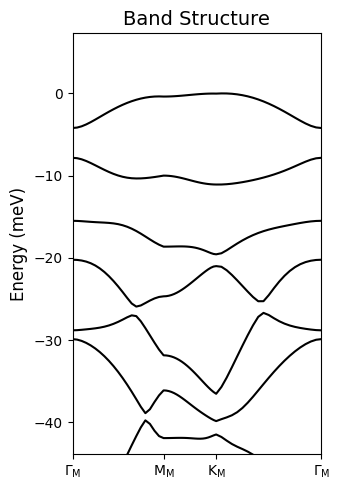

In [9]:
# ====================== Configuration Parameters ======================

# Model Configuration
material = "mote2_standard_basis"  # Name of the material
angle = '2.13'                      # Angle parameter as a string (e.g., '2.13')
model_type = 'reduced'                 # Type of model (e.g., 'full', 'reduced')

# Parallel Processing Configuration
n_jobs = 61  # Number of parallel jobs (set to -1 to use all available cores)

# Data Paths Configuration
path_model = "path/to/your/continue_model"  # Base path to the model data

# ====================== End of Configuration ======================

def main():
    """
    Main function to execute the band structure calculation and plotting.
    """
    global bM1, bM2, q1, q2, q3, Qlayer1

    # Load data
    path_model = "/home/zy/software/TAPW_tmdc/from_work/source_02/continue_model_github"
    os.chdir(path_model)
    Qlayer1 = np.loadtxt(f"./{material}/{model_type}/{angle}_Qlayer1.txt")
    Qlayer2 = np.loadtxt(f"./{material}/{model_type}/{angle}_Qlayer2.txt")
    coeff = load_json_data(f"./{material}/{model_type}/coeff_{angle}.json")
    m_coeff = coeff['diag']
    intra = coeff['intra']
    inter = coeff['inter']
    kpath_frac = np.loadtxt("./kpath.txt")
    Qset = np.concatenate((Qlayer1, Qlayer2), axis=0)

    # Define constants
    q_norm = np.min(np.linalg.norm(Qset, axis=1))
    q1 = np.array([0, q_norm])
    q2 = rot(q1, 120)
    q3 = rot(q1, 240)
    bM1 = np.array([np.sqrt(3) * q_norm, 0])
    bM2 = rot(bM1, 60)
    BM_mat = np.array([bM1, bM2])
    
    # Convert kpath to Cartesian coordinates
    kpath_cart = np.dot(kpath_frac[:, :2], BM_mat)
    for i in range(len(kpath_cart)):
        kpath_cart[i] = rot(kpath_cart[i], 0)  # Currently no rotation
    
    # Compute Fk0 matrices
    Fk0xmat = np.array([
        [-Q2[0] if np.allclose(Q1, Q2, atol=1e-5) else 0 for Q2 in Qset] 
        for Q1 in Qset
    ])
    Fk0ymat = np.array([
        [-Q2[1] if np.allclose(Q1, Q2, atol=1e-5) else 0 for Q2 in Qset] 
        for Q1 in Qset
    ])

    # Generate projection matrices
    C2yT_K1_valley_spin_up_proj(Qset)
    C3K1_valley_spin_up_proj(Qset)

    # Parallel eigenvalue computation
    eigenvalues_results, eigenvectors_results = parallel_eigen_solver_with_vectors(
        kpath_cart, Qset, m_coeff, intra, inter, Fk0xmat, Fk0ymat, n_jobs=n_jobs
    )

    # Adjust eigenvalues
    eigenvalues_results -= np.max(eigenvalues_results) 

    # Plotting
    fig, ax = plt.subplots(figsize=(3.5, 5))
    for i in range(len(Qset)):
        ax.plot(kpath_frac[:,3], eigenvalues_results[:, i], color='black')
    
    ymin = np.min(eigenvalues_results[:, -6]) * 1.1
    ymax = -ymin / 6
    xticks = np.array([0, kpath_frac[20,3], kpath_frac[40,3], kpath_frac[60,3]])
    xlabels = [
        r'${\Gamma}_{\mathrm{M}}$', 
        r'${\mathrm{M}}_{\mathrm{M}}$', 
        r'${\mathrm{K}}_{\mathrm{M}}$', 
        r'${\Gamma}_{\mathrm{M}}$'
    ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlim(0, kpath_frac[60,3])
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('Energy (meV)', fontsize=12)
    ax.set_title('Band Structure', fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [3]:
angle_list = ['2.13','2.45','2.65','2.88','3.15','3.48','3.89']
os.chdir("/home/zy/software/TAPW_tmdc/from_work/source_02/continue_model_github")
for angle in angle_list:
    os.system(f"mv ./mote2_standard_basis/reduced/{angle}_Qlayer1_less.txt ./mote2_standard_basis/reduced/{angle}_Qlayer1.txt")
    os.system(f"mv ./mote2_standard_basis/reduced/{angle}_Qlayer2_less.txt ./mote2_standard_basis/reduced/{angle}_Qlayer2.txt")
    os.system(f"mv ./mote2_quick_basis/reduced/{angle}_Qlayer1_less.txt ./mote2_quick_basis/reduced/{angle}_Qlayer1.txt")
    os.system(f"mv ./mote2_quick_basis/reduced/{angle}_Qlayer2_less.txt ./mote2_quick_basis/reduced/{angle}_Qlayer2.txt")
    os.system(f"mv ./wse2_quick_basis/reduced/{angle}_Qlayer1_less.txt ./wse2_quick_basis/reduced/{angle}_Qlayer1.txt")
    os.system(f"mv ./wse2_quick_basis/reduced/{angle}_Qlayer2_less.txt ./wse2_quick_basis/reduced/{angle}_Qlayer2.txt")